In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/skin-diseases/kaggle/val/4. Pigment/roi93.jpg
/kaggle/input/skin-diseases/kaggle/val/4. Pigment/freckles-1.jpg
/kaggle/input/skin-diseases/kaggle/val/4. Pigment/roi329.jpg
/kaggle/input/skin-diseases/kaggle/val/4. Pigment/vitiligo-57__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpg
/kaggle/input/skin-diseases/kaggle/val/4. Pigment/sun-damaged-skin-12.jpg
/kaggle/input/skin-diseases/kaggle/val/4. Pigment/colloid-milia-9.jpg
/kaggle/input/skin-diseases/kaggle/val/4. Pigment/porphyrias-51.jpg
/kaggle/input/skin-diseases/kaggle/val/4. Pigment/erythema-ab-igne-16.jpg
/kaggle/input/skin-diseases/kaggle/val/4. Pigment/phototoxic-reactions-108.jpg
/kaggle/input/skin-diseases/kaggle/val/4. Pigment/polymorphous-light-eruption-25.jpg
/kaggle/input/skin-diseases/kaggle/val/4. Pigment/roi332.jpg
/kaggle/input/skin-diseases/kaggle/val/4. Pigment/vitiligo-29.jpg
/kaggle/input/skin-diseases/kaggle/val/4. Pigment/vitiligo-24__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.j

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from transformers import SwinForImageClassification, AutoImageProcessor
from torch.cuda.amp import GradScaler, autocast
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [4]:
data_dir = {
    "train": "/kaggle/input/skin-diseases/kaggle/train",
    "val": "/kaggle/input/skin-diseases/kaggle/val",
    "test": "/kaggle/input/skin-diseases/kaggle/test"
}

In [ ]:
transform = transforms.Compose([
    transforms.Resize((384, 384)),  
    transforms.RandomHorizontalFlip(),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
])

In [6]:
train_dataset = datasets.ImageFolder(data_dir["train"], transform=transform)
val_dataset = datasets.ImageFolder(data_dir["val"], transform=transform)
test_dataset = datasets.ImageFolder(data_dir["test"], transform=transform)

In [7]:
print("Class-to-Index Mapping:", train_dataset.class_to_idx)

Class-to-Index Mapping: {'1. Enfeksiyonel': 0, '2. Ekzama': 1, '3. Akne': 2, '4. Pigment': 3, '5. Benign': 4, '6. Malign': 5}


In [8]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [9]:
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 30909
Validation set size: 3923
Test set size: 3928


In [10]:
model_name = "microsoft/swin-large-patch4-window12-384-in22k"
image_processor = AutoImageProcessor.from_pretrained(model_name)
model = SwinForImageClassification.from_pretrained(
    model_name,
    num_labels=len(train_dataset.classes),
    ignore_mismatched_sizes=True
).to(device)

preprocessor_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/919M [00:00<?, ?B/s]

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-large-patch4-window12-384-in22k and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([21841, 1536]) in the checkpoint and torch.Size([6, 1536]) in the model instantiated
- classifier.bias: found shape torch.Size([21841]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True

In [12]:
def set_seeds(seed: int = 42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

set_seeds()

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = OneCycleLR(optimizer, max_lr=3e-4, epochs=10, steps_per_epoch=len(train_loader), pct_start=0.2, anneal_strategy="cos")

scaler = GradScaler()

<ipython-input-13-a9b3a809ba8f>:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


<ipython-input-14-1ee0672d22d5>:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/10, Train Acc: 0.5053, Val Acc: 0.6215


<ipython-input-14-1ee0672d22d5>:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2/10, Train Acc: 0.6759, Val Acc: 0.7094


<ipython-input-14-1ee0672d22d5>:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3/10, Train Acc: 0.7307, Val Acc: 0.7428


<ipython-input-14-1ee0672d22d5>:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 4/10, Train Acc: 0.7618, Val Acc: 0.7660


<ipython-input-14-1ee0672d22d5>:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 5/10, Train Acc: 0.7776, Val Acc: 0.7706


<ipython-input-14-1ee0672d22d5>:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 6/10, Train Acc: 0.7869, Val Acc: 0.7843


<ipython-input-14-1ee0672d22d5>:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 7/10, Train Acc: 0.7970, Val Acc: 0.7882


<ipython-input-14-1ee0672d22d5>:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 8/10, Train Acc: 0.8040, Val Acc: 0.7889


<ipython-input-14-1ee0672d22d5>:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 9/10, Train Acc: 0.8067, Val Acc: 0.7963


<ipython-input-14-1ee0672d22d5>:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 10/10, Train Acc: 0.8120, Val Acc: 0.7948


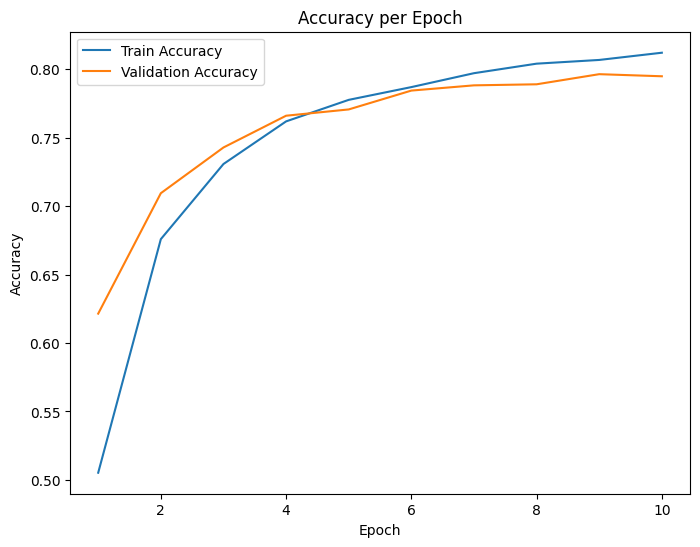

In [14]:
num_epochs = 10
train_acc_history, val_acc_history = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss, train_preds, train_labels = 0, [], []

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        with autocast():
            outputs = model(images).logits
            loss = criterion(outputs, labels) / 2
        scaler.scale(loss).backward()

        if (batch_idx + 1) % 2 == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            scheduler.step()

        train_loss += loss.item()
        train_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    train_acc = accuracy_score(train_labels, train_preds)
    train_acc_history.append(train_acc)

    # Validation
    model.eval()
    val_preds, val_labels = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            val_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_acc = accuracy_score(val_labels, val_preds)
    val_acc_history.append(val_acc)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_acc_history, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_acc_history, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.legend()
plt.show()

In [ ]:
def evaluate_model(model, dataloader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for images, labels_batch in dataloader:
            images, labels_batch = images.to(device), labels_batch.to(device)
            outputs = model(images).logits
            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels.extend(labels_batch.cpu().numpy())
    return labels, preds

train_labels, train_preds = evaluate_model(model, train_loader)
val_labels, val_preds = evaluate_model(model, val_loader)
test_labels, test_preds = evaluate_model(model, test_loader)

In [16]:
print("Train Classification Report:")
print(classification_report(train_labels, train_preds, target_names=train_dataset.classes))

print("Validation Classification Report:")
print(classification_report(val_labels, val_preds, target_names=val_dataset.classes))

print("Test Classification Report:")
print(classification_report(test_labels, test_preds, target_names=test_dataset.classes))

Train Classification Report:
                 precision    recall  f1-score   support

1. Enfeksiyonel       0.71      0.84      0.77      6000
      2. Ekzama       0.77      0.71      0.74      4070
        3. Akne       0.83      0.87      0.85      2148
     4. Pigment       0.80      0.60      0.69      1020
      5. Benign       0.87      0.87      0.87     10888
      6. Malign       0.87      0.79      0.83      6783

       accuracy                           0.82     30909
      macro avg       0.81      0.78      0.79     30909
   weighted avg       0.82      0.82      0.82     30909

Validation Classification Report:
                 precision    recall  f1-score   support

1. Enfeksiyonel       0.67      0.81      0.74       750
      2. Ekzama       0.74      0.65      0.69       508
        3. Akne       0.83      0.81      0.82       322
     4. Pigment       0.74      0.53      0.62       135
      5. Benign       0.85      0.86      0.86      1361
      6. Malign      

In [17]:
def plot_confusion_matrix(labels, preds, title):
    conf_matrix = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=train_dataset.classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

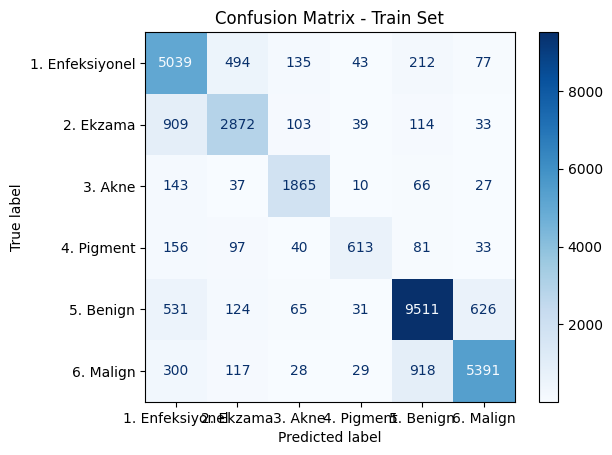

In [18]:
plot_confusion_matrix(train_labels, train_preds, "Confusion Matrix - Train Set")


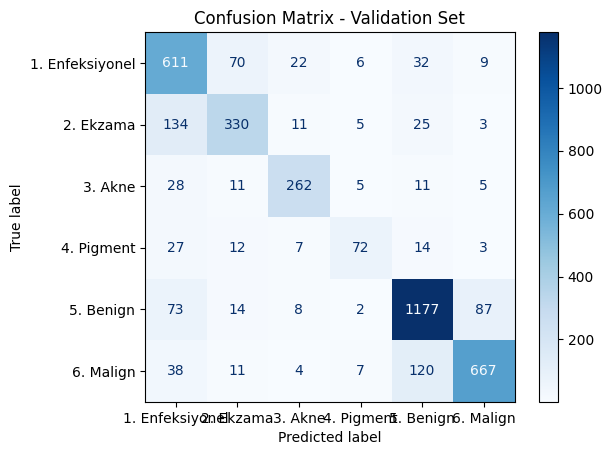

In [19]:
plot_confusion_matrix(val_labels, val_preds, "Confusion Matrix - Validation Set")


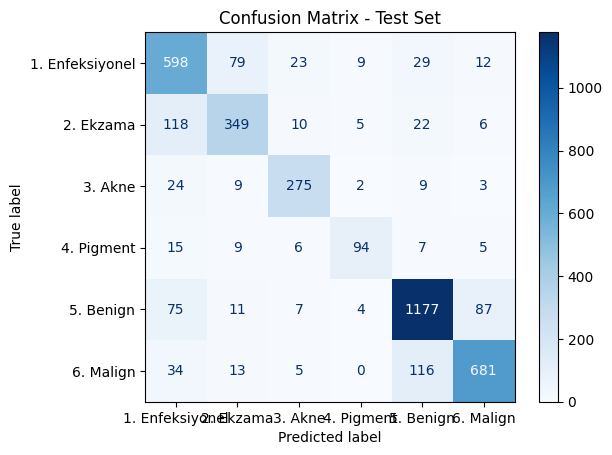

In [20]:
plot_confusion_matrix(test_labels, test_preds, "Confusion Matrix - Test Set")


In [21]:
torch.save(model.state_dict(), "swin_skin_disease_model.pth")
print("Model saved successfully!")

Model saved successfully!


Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-large-patch4-window12-384-in22k and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([21841, 1536]) in the checkpoint and torch.Size([6, 1536]) in the model instantiated
- classifier.bias: found shape torch.Size([21841]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-25-866598b47df5>:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will 

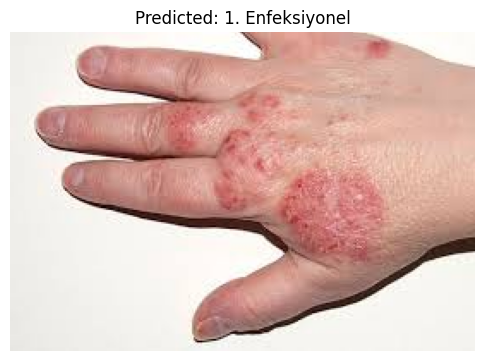

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from transformers import SwinForImageClassification, AutoImageProcessor

device = "cuda" if torch.cuda.is_available() else "cpu"

image_path = "/kaggle/input/pvt-skin/images.jpg"
model_path = "/kaggle/working/swin_skin_disease_model.pth"

model_name = "microsoft/swin-large-patch4-window12-384-in22k"
model = SwinForImageClassification.from_pretrained(
    model_name,
    num_labels=6,  
    ignore_mismatched_sizes=True  
).to(device)


model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()


transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

image = Image.open(image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0).to(device)

with torch.no_grad():
    output = model(input_tensor).logits
    predicted_class = torch.argmax(output, dim=1).item()

class_labels = ['1. Enfeksiyonel', '2. Ekzama', '3. Akne', '4. Pigment', '5. Benign', '6. Malign']
predicted_label = class_labels[predicted_class]

plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis("off")
plt.title(f"Predicted: {predicted_label}")
plt.show()


Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-large-patch4-window12-384-in22k and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([21841, 1536]) in the checkpoint and torch.Size([6, 1536]) in the model instantiated
- classifier.bias: found shape torch.Size([21841]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-26-cd63be450582>:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will 

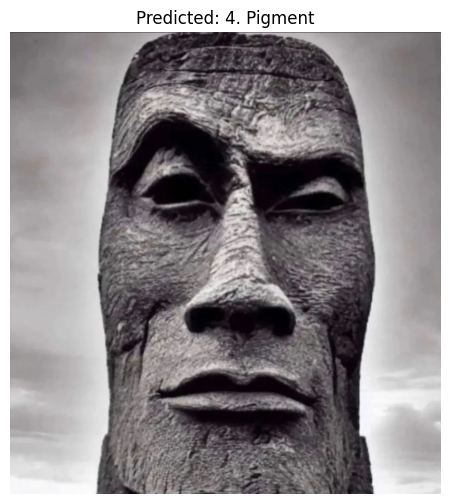

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from transformers import SwinForImageClassification, AutoImageProcessor

device = "cuda" if torch.cuda.is_available() else "cpu"

image_path = "/kaggle/input/pvt-skin/SmartSelect_20221226-214520_Instagram.jpg"
model_path = "/kaggle/working/swin_skin_disease_model.pth"

model_name = "microsoft/swin-large-patch4-window12-384-in22k"
model = SwinForImageClassification.from_pretrained(
    model_name,
    num_labels=6,  
    ignore_mismatched_sizes=True  
).to(device)

model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

image = Image.open(image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0).to(device)

with torch.no_grad():
    output = model(input_tensor).logits
    predicted_class = torch.argmax(output, dim=1).item()

class_labels = ['1. Enfeksiyonel', '2. Ekzama', '3. Akne', '4. Pigment', '5. Benign', '6. Malign']
predicted_label = class_labels[predicted_class]

plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis("off")
plt.title(f"Predicted: {predicted_label}")
plt.show()
